In [1]:
run calcIsotopologues.py

In [43]:
run simulateMeasurements.py

In [3]:
############################################################################################################
###  First, initialize the molecule and the fragments we will be looking at. This includes an "IDList",  ###
###  which gives names to the sites, "elIDs", giving their chemical element, "numberAtSite", giving the  ###
###  number of atoms per site, "deltas", giving delta 13C vs PDB, 17O vs VSMOW, 33S vs CDT, 15N vs AIR,  ###
###  and D vs VSMOW. 18O and 34/36S are assigned delta values based on mass scaling laws. The details    ###
###  can be find in the basicDeltaOperations file.                                                       ###
###                                                                                                      ###
###  We then initialize the fragments, giving them entries of 1 or 'x' to indicate sites which are       ###
###  retained or lost. We put all this information into a dataFrame to easily check.                     ###
###                                                                                                      ###
############################################################################################################

#Define the "set of element isotopes" for each chemical element
subsDict = {'H':(0,1),'N':(0,1),'C':(0,1),'O':(0,1,2),'S':(0,1,2,4)}

##### INITIALIZE SITES #####
IDList = ['Cmethyl','Cgamma','Calphabeta','Ccarboxyl','Ocarboxyl1','Ocarboxyl2','Ssulfur','Namine','Hmethyl','Hgamma',
         'Halphabeta','Hamine','Hhydroxyl','Hprotonated']
elIDs = ['C','C','C','C','O','O','S','N','H','H','H','H','H','H']
numberAtSite = [1,1,2,1,1,1,1,1,3,2,3,2,1,1]

deltas = [-45,-35,-30,-25,-13,-13,2.5,10,-250,-100,0,100,250,0]

frag_full = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
frag_133 = [1,1,1,1,1,1,1,'x',1,1,1,'x',1,'x']
frag_104 = [1,1,1,'x','x','x',1,1,1,1,1,1,'x','x']
frag_102 = ['x',1,1,1,1,1,'x',1,'x',1,1,1,1,'x']
#88 and both 74 are incorrect but right stoich for predictions
#C3H8ON
#C2H4O2N
frag_88 = [1,1,1,'x','x','x',1,'x',1,1,'x',1,'x','x']
frag_74High = [1,'x',1,'x',1,'x','x',1,1,1,1,'x','x','x']
frag_74Low = [1,1,'x','x',1,1,'x',1,'x',1,'x',1,'x','x']
frag_61 = [1,1,'x','x','x','x',1,'x',1,1,'x','x','x','x']
frag_56 = ['x',1,1,'x','x','x','x',1,'x',1,1,'x',1,'x']

l = [elIDs, numberAtSite, deltas, frag_full, frag_133, frag_104, frag_102,
     frag_88, frag_74High, frag_74Low, frag_61, frag_56]

df = pd.DataFrame(l, columns = IDList)
df = df.transpose()
df.columns = ['IDS','Number','deltas','frag_full','frag_133','frag_104','frag 102',
                  'frag_88','frag_74High','frag_74Low','frag 61','frag 56']

In [4]:
df

,IDS,Number,deltas,frag_full,frag_133,frag_104,frag 102,frag_88,frag_74High,frag_74Low,frag 61,frag 56
Cmethyl,C,1,-45,1,1,1,x,1,1,1,1,x
Cgamma,C,1,-35,1,1,1,1,1,x,1,1,1
Calphabeta,C,2,-30,1,1,1,1,1,1,x,x,1
Ccarboxyl,C,1,-25,1,1,x,1,x,x,x,x,x
Ocarboxyl1,O,1,-13,1,1,x,1,x,1,1,x,x
Ocarboxyl2,O,1,-13,1,1,x,1,x,x,1,x,x
Ssulfur,S,1,2.5,1,1,1,x,1,x,x,1,x
Namine,N,1,10,1,x,1,1,x,1,1,x,1
Hmethyl,H,3,-250,1,1,1,x,1,1,x,1,x
Hgamma,H,2,-100,1,1,1,1,1,1,1,1,1


The following steps calculate all isotopologues of a molecule and their concentrations. We encourage the user to look at what each of these variables are and correlate them to data objects from the M+N paper; they should be familiar. 

In [5]:
#This is the one variable that won't be correlated--it is a computational aid we will use later
siteElements = strSiteElements(df)

In [6]:
siteIsotopes, multinomialCoeff = calculateSetsOfSiteIsotopes(df)

In [7]:
bigA, SN = calcAllIsotopologues(siteIsotopes, multinomialCoeff)

In [8]:
concentrationArray = siteSpecificConcentrations(df)
d = calculateIsotopologueConcentrations(bigA, SN, concentrationArray)

In [9]:
bySub = calcSubDictionary(d, df)

In [10]:
byCondensed = calcCondensedDictionary(d, df)

In [11]:
###Should be = 1, minus floating point error
s = 0
for i, v in byCondensed.items():
    s += v['Conc']
print(s)

s = 0
for i, v in bySub.items():
    s += v['Conc']
print(s)

0.999999999999888
0.9999999999999984


Then we simulate the measurements we are interested in 

In [12]:
stochD = copy.deepcopy(byCondensed)
clumpD = copy.deepcopy(byCondensed)

In [13]:
###Clumped amounts for a given cap delta are calculated via an excel spreadsheet at the moment. 
###I do not have a generalized way to do so. 
#COClump = 1.4637E-09
COClump = 0

clumpD['000010100000000000000']['Conc'] += COClump
clumpD['000011000000000000000']['Conc'] += COClump
clumpD['000010000000000000000']['Conc'] -= COClump
clumpD['000000100000000000000']['Conc'] -= COClump
clumpD['000001000000000000000']['Conc'] -= COClump
clumpD['000000000000000000000']['Conc'] += COClump

In [14]:
#NHClump = -2.2662E-10
NHClump = 0

clumpD['000000001000000000100']['Conc'] += NHClump * 2
clumpD['000000001000000000000']['Conc'] -= NHClump
clumpD['000000000000000000100']['Conc'] -= NHClump * 2
clumpD['000000000000000000000']['Conc'] += NHClump

In [15]:
SDClump = 0

clumpD['000000010000010000000']['Conc'] += SDClump * 2
clumpD['000000000000010000000']['Conc'] -= SDClump * 2
clumpD['000000010000000000000']['Conc'] -= SDClump
clumpD['000000000000000000000']['Conc'] += SDClump

In [16]:
a = stochD['000010100000000000000']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000010100000000000000']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

a = stochD['000011000000000000000']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000011000000000000000']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

0.0
0.0


In [17]:
a = stochD['000000001000000000100']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000000001000000000100']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

0.0


In [18]:
###Note this is slightly <0 for a clump of 0. This is *not* a floating point error, but a real thing, as the 
###concentration of ['0...0'] is less than stochastic due to the clumps at other positions. 

a = stochD['000000010000010000000']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000000010000010000000']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

0.0


In [34]:
allMeasurementInfo = {}
allMeasurementInfo = directMeasurement(bySub, allMeasurementInfo, massThreshold = 4)

In [47]:
MN = massSelections(byCondensed, massThreshold = 4)

condensedFrags = [frag_133, frag_104, frag_102, frag_61, frag_56]
expandedFrags = [expandFrag(x, numberAtSite) for x in condensedFrags]
fragKeys = ['133','104','102','61','56']

In [65]:
predictMNFragmentExpt(allMeasurementInfo, MN, expandedFrags, fragKeys, df, abundanceThreshold = 0.001)

{'Full': {'': 0.8903107299253543,
  'D': 0.0016640975915180785,
  'DD': 1.4255991247017077e-06,
  'DDD': 7.401710655451268e-10,
  'DDDD': 2.5940035163094504e-13,
  '15N': 0.0032727822432056025,
  '15ND': 6.117222746420457e-06,
  '15NDD': 5.240502382403478e-09,
  '15NDDD': 2.7208688369438867e-12,
  '33S': 0.0070295089092552695,
  '33SD': 1.3138995692467212e-05,
  '33SDD': 1.1255914829822815e-08,
  '33SDDD': 5.844070979644004e-12,
  '33S15N': 2.5840474750422375e-05,
  '33S15ND': 4.829894816550948e-08,
  '33S15NDD': 4.137674291442867e-11,
  '34S': 0.039833883819113194,
  '34SD': 7.445430892398085e-05,
  '34SDD': 6.378351736899595e-08,
  '34S15N': 0.00014642935691906012,
  '34S15ND': 2.736940396045537e-07,
  '36S': 9.372657178216173e-05,
  '17O': 0.0006764580925972842,
  '17OD': 1.2643813500354363e-06,
  '17ODD': 1.0831702149483574e-09,
  '17ODDD': 5.62381975601187e-13,
  '17O15N': 2.486659948387617e-06,
  '17O15ND': 4.647865842730263e-09,
  '17O15NDD': 3.981733710150163e-12,
  '17O33S': 5

In [66]:
fullMoleculeU = ['13C','15N','33S','34S','17O','18O','D','13C18O','13C34S','34S15N','18O15N',
                '18O34S','18O18O','36S',]
ratios = ['D/34S','17O/34S','33S/34S','15N/34S','13C13C/34S',
         '18O/34S','13C33S/34S','13C18O/34S','13C34S/34S',
         '17O34S/34S','34S15N/34S','34SD/13C34S','18O33S/13C34S',
         '13C13C34S/13C34S','18O34S/13C34S','36S/13C34S',
         '13C34S15N/36S','13C34SD/36S','18O18O/36S',
         '13C13C18O/36S']

out = measurementToDf(allMeasurementInfo, bySub, fullMoleculeU = fullMoleculeU, ratios = ratios)

In [67]:
out

,Abs. Abundance,Rel. Abundance,Adj. Rel. Abundance
13C U Value,0.054781350000000,0.054781350000000,0.054781350000000
15N U Value,0.003676000000000,0.003676000000000,0.003676000000000
33S U Value,0.007895568000000,0.007895568000000,0.007895568000000
34S U Value,0.044741552000000,0.044741552000000,0.044741552000000
17O U Value,0.000759800000000,0.000759800000000,0.000759800000000
18O U Value,0.004010400000000,0.004010400000000,0.004010400000000
D U Value,0.001869120000000,0.001869120000000,0.001869120000000
13C18O U Value,0.000219695126040,0.000219695126040,0.000219695126040
13C34S U Value,0.002451002619655,0.002451002619655,0.002451002619655
34S15N U Value,0.000164469945152,0.000164469945152,0.000164469945152


In [69]:
pd.set_option("precision", 15)
pd.set_option('display.max_rows', 500)
out

,Abs. Abundance,Rel. Abundance,Adj. Rel. Abundance
13C U Value,0.054781350000000,0.054781350000000,0.054781350000000
15N U Value,0.003676000000000,0.003676000000000,0.003676000000000
33S U Value,0.007895568000000,0.007895568000000,0.007895568000000
34S U Value,0.044741552000000,0.044741552000000,0.044741552000000
17O U Value,0.000759800000000,0.000759800000000,0.000759800000000
18O U Value,0.004010400000000,0.004010400000000,0.004010400000000
D U Value,0.001869120000000,0.001869120000000,0.001869120000000
13C18O U Value,0.000219695126040,0.000219695126040,0.000219695126040
13C34S U Value,0.002451002619655,0.002451002619655,0.002451002619655
34S15N U Value,0.000164469945152,0.000164469945152,0.000164469945152


In [70]:
out.to_csv('M+N Methionine Approximate one hundretnt.csv')

We can generate simulated spectra in the following way

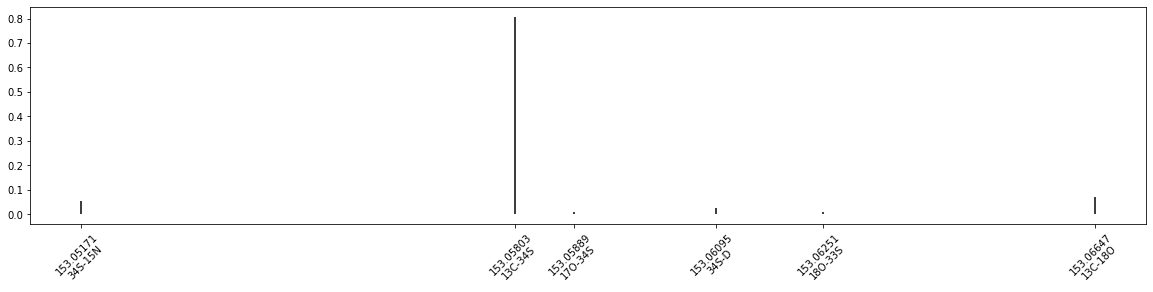

In [54]:
import matplotlib.pyplot as plt

#####PREDICT FULL SPECTRUM (NO FRAGMENT) #####
#####CUT OFF ISOTOPOLOGUES WITH LOW REL ABUNDANCE #####

##### TO DO: Integrate this with remainder of the code #####
selectedIsotopologues = MN['M3']
lowAbundanceCutOff = 0.01
massError = -0.000


predictSpectrum = {}
for key, item in selectedIsotopologues.items():
    mass = computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = computeSubs(key, siteElements)
    
    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}
        
        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs
            
    predictSpectrum[correctedMass]['Abs. Abundance'] += item['Conc']
    
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']
    
massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
fig, ax = plt.subplots(figsize = (20,4))
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
    

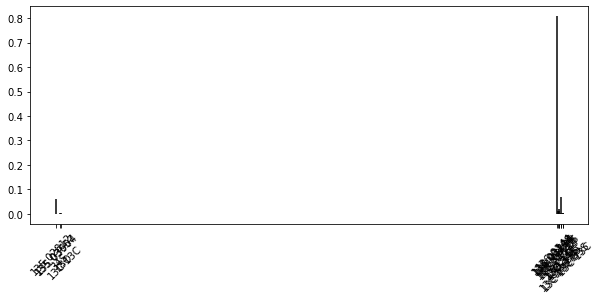

In [56]:
##### PREDICT SPECTRUM WITH FRAGMENTATION #####
selectedIsotopologues = MN["M3"]
lowAbundanceCutOff = 0.001
massError = 0.000
fragment = expandFrag(frag_133, list(df['Number'].values))
bounds = None

##### Fragment Isotopologues #####
fragmentedDict = {}
for isotopologue, data in selectedIsotopologues.items():
    frag = [fragMult(x,y) for x, y in zip(fragment, isotopologue)]
    newIsotopologue = ''.join(frag)
    if newIsotopologue not in fragmentedDict:
        fragmentedDict[newIsotopologue] = 0
    fragmentedDict[newIsotopologue] += data['Conc']

selectedIsotopologues = fragmentedDict


##### Predict Spectrum #####
predictSpectrum = {}
for key, item in selectedIsotopologues.items():
    mass = computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = computeSubs(key, siteElements)
    
    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}
        
        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs
            
    predictSpectrum[correctedMass]['Abs. Abundance'] += item
    
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']
    
massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
fig, ax = plt.subplots(figsize = (10,4))
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
if bounds != None:
    ax.set_xlim(bounds[0],bounds[1])
#ax.set_xlim(107.035, 107.07)
    

In [63]:
###See below for an interesting sidenote...

In [57]:
f61 = {}
frag_61Full = expandFrag(frag_61, numberAtSite)
for isotopologue, v in clumpD.items():
    frag = [fragMult(x,y) for x, y in zip(frag_61Full, isotopologue)]
    newIsotopologue = ''.join(frag)
    if newIsotopologue not in f61:
        f61[newIsotopologue] = {'Conc':0,'Number':0,'Sources':0,'Mass':0,'Subs':''}
    f61[newIsotopologue]['Conc'] += v['Conc']
    f61[newIsotopologue]['Number'] += v['Number']
    f61[newIsotopologue]['Sources'] += 1
    f61[newIsotopologue]['Mass'] = computeMass(newIsotopologue, siteElements)
    f61[newIsotopologue]['Subs'] = computeSubs(newIsotopologue, siteElements)

In [58]:
f61

{'00xxxxx0x00000xxxxxxx': {'Conc': 0.9289362312164786,
  'Number': 18432,
  'Sources': 5184,
  'Mass': 61.01119633,
  'Subs': ''},
 '00xxxxx0x00001xxxxxxx': {'Conc': 0.0002604439932737,
  'Number': 36864,
  'Sources': 5184,
  'Mass': 62.017473075999995,
  'Subs': 'D'},
 '00xxxxx0x00011xxxxxxx': {'Conc': 1.8255040376540284e-08,
  'Number': 18432,
  'Sources': 5184,
  'Mass': 63.02374982199999,
  'Subs': 'D-D'},
 '00xxxxx0x00100xxxxxxx': {'Conc': 0.0003255549915921264,
  'Number': 55296,
  'Sources': 5184,
  'Mass': 62.017473075999995,
  'Subs': 'D'},
 '00xxxxx0x00101xxxxxxx': {'Conc': 9.127520188270123e-08,
  'Number': 110592,
  'Sources': 5184,
  'Mass': 63.02374982199999,
  'Subs': 'D-D'},
 '00xxxxx0x00111xxxxxxx': {'Conc': 6.397661450362309e-12,
  'Number': 55296,
  'Sources': 5184,
  'Mass': 64.030026568,
  'Subs': 'D-D-D'},
 '00xxxxx0x01100xxxxxxx': {'Conc': 3.8031334117792245e-08,
  'Number': 55296,
  'Sources': 5184,
  'Mass': 63.02374982199999,
  'Subs': 'D-D'},
 '00xxxxx0x01101

In [59]:
subList = []
numList = []
sourceList = []
iD = []
for i, v in f61.items():
    subList.append(v['Subs'])
    numList.append(v['Number'])
    sourceList.append(v['Sources'])
    iD.append(i)
    
    

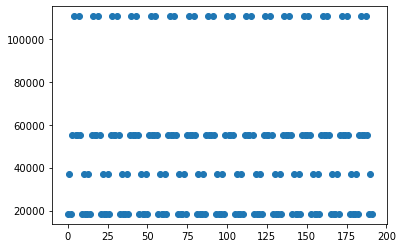

In [60]:
###The number of isotopologues contributing to every fragment of the 61 fragment of methionine. 
###Each is a scalar multiple of some constant; the scalar depends on the symmetry number of the isotopologue. 
###I don't know what to do with this information, but it is interesting. At some point there may be a clever
###computational way to take advantage of it. 

###Something similar occurs with the fine isotope structure of directly fragmented peaks. 

plt.scatter(range(len(numList)),numList)

In [61]:
3456 * len(sourceList)

663552

In [62]:
len(sourceList)

192

In [ ]:
#A standard which it may be useful to recalculate sometime
'''
############################################################################################################
###  First, initialize the molecule and the fragments we will be looking at. This includes an "IDList",  ###
###  which gives names to the sites, "elIDs", giving their chemical element, "numberAtSite", giving the  ###
###  number of atoms per site, "deltas", giving delta 13C vs PDB, 17O vs VSMOW, 33S vs CDT, 15N vs AIR,  ###
###  and D vs VSMOW. 18O and 34/36S are assigned delta values based on mass scaling laws. The details    ###
###  can be find in the basicDeltaOperations file.                                                       ###
###                                                                                                      ###
###  We then initialize the fragments, giving them entries of 1 or 'x' to indicate sites which are       ###
###  retained or lost. We put all this information into a dataFrame to easily check.                     ###
###                                                                                                      ###
############################################################################################################

#Define the "set of element isotopes" for each chemical element
subsDict = {'H':(0,1),'N':(0,1),'C':(0,1),'O':(0,1,2),'S':(0,1,2,4)}

##### INITIALIZE SITES #####
IDList = ['Cmethyl','Cgamma','Calphabeta','Ccarboxyl','Ocarboxyl1','Ocarboxyl2','Ssulfur','Namine','Hmethyl','Hgamma',
         'Halphabeta','Hamine','Hhydroxyl','Hprotonated']
elIDs = ['C','C','C','C','O','O','S','N','H','H','H','H','H','H']
numberAtSite = [1,1,2,1,1,1,1,1,3,2,3,2,1,1]

deltas = [-25,-25,-25,-25,0,0,0,0,0,0,0,0,0,0]

frag_full = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
frag_133 = [1,1,1,1,1,1,1,'x',1,1,1,'x',1,'x']
frag_104 = [1,1,1,'x','x','x',1,1,1,1,1,1,'x','x']
frag_102 = ['x',1,1,1,1,1,'x',1,'x',1,1,1,1,'x']
#88 and both 74 are incorrect but right stoich for predictions
#C3H8ON
#C2H4O2N
frag_88 = [1,1,1,'x','x','x',1,'x',1,1,'x',1,'x','x']
frag_74High = [1,'x',1,'x',1,'x','x',1,1,1,1,'x','x','x']
frag_74Low = [1,1,'x','x',1,1,'x',1,'x',1,'x',1,'x','x']
frag_61 = [1,1,'x','x','x','x',1,'x',1,1,'x','x','x','x']
frag_56 = ['x',1,1,'x','x','x','x',1,'x',1,1,'x',1,'x']

l = [elIDs, numberAtSite, deltas, frag_full, frag_133, frag_104, frag_102,
     frag_88, frag_74High, frag_74Low, frag_61, frag_56]

df = pd.DataFrame(l, columns = IDList)
df = df.transpose()
df.columns = ['IDS','Number','deltas','frag_full','frag_133','frag_104','frag 102',
                  'frag_88','frag_74High','frag_74Low','frag 61','frag 56']

#This is the one variable that won't be correlated--it is a computational aid we will use later
siteElements = strSiteElements(df)

siteIsotopes, multinomialCoeff = calculateSetsOfSiteIsotopes(df)

bigA, SN = calcAllIsotopologues(siteIsotopes, multinomialCoeff)

concentrationArray = siteSpecificConcentrations(df)
d = calculateIsotopologueConcentrations(bigA, SN, concentrationArray)

bySub = calcSubDictionary(d, df)

byCondensed = calcCondensedDictionary(d, df)

###Should be = 1, minus floating point error
s = 0
for i, v in byCondensed.items():
    s += v['Conc']
print(s)

s = 0
for i, v in bySub.items():
    s += v['Conc']
print(s)

allMeasurementInfo = {}
allMeasurementInfo = directMeasurement(bySub, allMeasurementInfo, massThreshold = 4)

MN = massSelections(byCondensed, massThreshold = 4)

condensedFrags = [frag_133, frag_104, frag_102, frag_61, frag_56]
expandedFrags = [expandFrag(x, numberAtSite) for x in condensedFrags]
fragKeys = ['133','104','102','61','56']

predictMNFragmentExpt(allMeasurementInfo, MN, expandedFrags, fragKeys, df, abundanceThreshold = 0)

fullMoleculeU = ['13C','15N','33S','34S','17O','18O','D','13C18O','13C34S','34S15N','18O15N',
                '18O34S','18O18O','36S',]
ratios = ['D/34S','17O/34S','33S/34S','15N/34S','13C13C/34S',
         '18O/34S','13C33S/34S','13C18O/34S','13C34S/34S',
         '17O34S/34S','34S15N/34S','34SD/13C34S','18O33S/13C34S',
         '13C13C34S/13C34S','18O34S/13C34S','36S/13C34S',
         '13C34S15N/36S','13C34SD/36S','18O18O/36S',
         '13C13C18O/36S']

out = measurementToDf(allMeasurementInfo, bySub, fullMoleculeU = fullMoleculeU, ratios = ratios)


pd.set_option("precision", 15)
pd.set_option('display.max_rows', 500)

out.to_csv('M+N Methionine Standad Exact Changed.csv')
'''